In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/My Drive

/content/gdrive/My Drive


In [3]:
# Hugging Face의 트랜스포머 모델을 설치
!pip install transformers

     |████████████████████████████████| 1.1MB 2.8MB/s 
     |████████████████████████████████| 3.0MB 15.8MB/s 
     |████████████████████████████████| 1.1MB 35.4MB/s 
     |████████████████████████████████| 890kB 42.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=8f702d6c8abe9c2a03ce813b2294ed90fab929a891d7e6852154e11516630d5f
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [4]:
import tensorflow as tf
import torch

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import random
import time
import datetime

<br>
<br>

# **데이터 로드**

In [5]:
# 디렉토리의 파일 목록
!ls nsmc -la

total 38174
drwx------ 2 root root     4096 Oct 12 12:29 code
drwx------ 2 root root     4096 Oct 12 12:29 .git
-rw------- 1 root root  4893335 Oct 12 12:29 ratings_test.txt
-rw------- 1 root root 14628807 Oct 12 12:29 ratings_train.txt
-rw------- 1 root root 19515078 Oct 12 12:29 ratings.txt
drwx------ 2 root root     4096 Oct 12 12:29 raw
-rw------- 1 root root     2596 Oct 12 12:29 README.md
-rw------- 1 root root    36746 Oct 12 12:32 synopses.json


In [6]:
# 판다스로 훈련셋과 테스트셋 데이터 로드
train = pd.read_csv("nsmc/ratings_train.txt", sep='\t')
test = pd.read_csv("nsmc/ratings_test.txt", sep='\t')

print(train.shape)
print(test.shape)

(150000, 3)
(50000, 3)


In [7]:
# 훈련셋의 앞부분 출력
train.tail(10)

,id,document,label
149990,6373651,이걸 영화라고 찎었냐?,0
149991,9492905,http://blog.naver.com/oroblast/220215679580 나쁜...,1
149992,9335962,공포나 재난영화가 아니라 아예 대놓고 비급 크리쳐개그물임ㅋㅋ 음악 완전 흥겹다ㅋ 5...,0
149993,10020916,For Carl.칼 세이건으로 시작해서 칼 세이건으로 끝난다.,1
149994,9458520,디케이드 다음에 더블 다음에 오즈인데 더블은 조금밖에 안나오네요.,1
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1
149999,9619869,한국 영화 최초로 수간하는 내용이 담긴 영화,0


<br>
<br>

# **전처리 - 훈련셋**

In [8]:
# 리뷰 문장 추출
sentences = train['document']
sentences[:10]

0                                  아 더빙.. 진짜 짜증나네요 목소리
1                    흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
2                                    너무재밓었다그래서보는것을추천한다
3                        교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
4    사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...
5        막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.
6                                원작의 긴장감을 제대로 살려내지못했다.
7    별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...
8                               액션이 없는데도 재미 있는 몇안되는 영화
9        왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?
Name: document, dtype: object

In [9]:
# BERT의 입력 형식에 맞게 변환
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
sentences[:10]

['[CLS] 아 더빙.. 진짜 짜증나네요 목소리 [SEP]',
 '[CLS] 흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나 [SEP]',
 '[CLS] 너무재밓었다그래서보는것을추천한다 [SEP]',
 '[CLS] 교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정 [SEP]',
 '[CLS] 사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다 [SEP]',
 '[CLS] 막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움. [SEP]',
 '[CLS] 원작의 긴장감을 제대로 살려내지못했다. [SEP]',
 '[CLS] 별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단 낫겟다 납치.감금만반복반복..이드라마는 가족도없다 연기못하는사람만모엿네 [SEP]',
 '[CLS] 액션이 없는데도 재미 있는 몇안되는 영화 [SEP]',
 '[CLS] 왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나? [SEP]']

In [10]:
# 라벨 추출
labels = train['label'].values
labels

array([0, 1, 0, ..., 0, 1, 0])

In [11]:
# BERT의 토크나이저로 문장을 토큰으로 분리
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

print (sentences[0])
print (tokenized_texts[0])


[CLS] 아 더빙.. 진짜 짜증나네요 목소리 [SEP]
['[CLS]', '아', '더', '##빙', '.', '.', '진', '##짜', '짜', '##증', '##나', '##네', '##요', '목', '##소', '##리', '[SEP]']


In [12]:
# 입력 토큰의 최대 시퀀스 길이
MAX_LEN = 128

# 토큰을 숫자 인덱스로 변환
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

input_ids[0]

array([   101,   9519,   9074, 119005,    119,    119,   9708, 119235,
         9715, 119230,  16439,  77884,  48549,   9284,  22333,  12692,
          102,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
      

In [13]:
# 어텐션 마스크 초기화
attention_masks = []

# 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
# 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

print(attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [14]:
# 훈련셋과 검증셋으로 분리
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids,
                                                                                    labels, 
                                                                                    random_state=2018, 
                                                                                    test_size=0.1)

# 어텐션 마스크를 훈련셋과 검증셋으로 분리
train_masks, validation_masks, _, _ = train_test_split(attention_masks, 
                                                       input_ids,
                                                       random_state=2018, 
                                                       test_size=0.1)

# 데이터를 파이토치의 텐서로 변환
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)				

print(train_inputs[0])
print(train_labels[0])
print(train_masks[0])
print(validation_inputs[0])
print(validation_labels[0])
print(validation_masks[0])

tensor([   101,   9711,  11489,   9364,  41850,   9004,  32537,   9491,  35506,
         17360,  48549,    119,    119,   9477,  26444,  12692,   9665,  21789,
         11287,   9708, 119235,   9659,  22458, 119136,  12965,  48549,    119,
           119,   9532,  22879,   9685,  16985,  14523,  48549,    119,    119,
          9596, 118728,    119,    119,   9178, 106065, 118916,    119,    119,
          8903,  11664,  11513,   9960,  14423,  25503, 118671,  48549,    119,
           119,  21890,   9546,  37819,  22879,   9356,  14867,   9715, 119230,
        118716,  48345,    119,   9663,  23321,  10954,   9638,  35506, 106320,
         10739,  20173,   9359,  19105,  11102,  42428,  17196,  48549,    119,
           119,    100,    117,   9947,  12945,   9532,  25503,   8932,  14423,
         35506, 119050,  11903,  14867,  10003,  14863,  33188,  48345,    119,
           102,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0, 

In [15]:
# 배치 사이즈
batch_size = 32

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

<br>
<br>

# **전처리 - 테스트셋**

In [16]:
# 리뷰 문장 추출
sentences = test['document']
sentences[:10]

0                                                  굳 ㅋ
1                                 GDNTOPCLASSINTHECLUB
2               뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아
3                     지루하지는 않은데 완전 막장임... 돈주고 보기에는....
4    3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??
5                                   음악이 주가 된, 최고의 음악영화
6                                              진정한 쓰레기
7             마치 미국애니에서 튀어나온듯한 창의력없는 로봇디자인부터가,고개를 젖게한다
8    갈수록 개판되가는 중국영화 유치하고 내용없음 폼잡다 끝남 말도안되는 무기에 유치한c...
9       이별의 아픔뒤에 찾아오는 새로운 인연의 기쁨 But, 모든 사람이 그렇지는 않네..
Name: document, dtype: object

In [17]:
# BERT의 입력 형식에 맞게 변환
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
sentences[:10]

['[CLS] 굳 ㅋ [SEP]',
 '[CLS] GDNTOPCLASSINTHECLUB [SEP]',
 '[CLS] 뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아 [SEP]',
 '[CLS] 지루하지는 않은데 완전 막장임... 돈주고 보기에는.... [SEP]',
 '[CLS] 3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠?? [SEP]',
 '[CLS] 음악이 주가 된, 최고의 음악영화 [SEP]',
 '[CLS] 진정한 쓰레기 [SEP]',
 '[CLS] 마치 미국애니에서 튀어나온듯한 창의력없는 로봇디자인부터가,고개를 젖게한다 [SEP]',
 '[CLS] 갈수록 개판되가는 중국영화 유치하고 내용없음 폼잡다 끝남 말도안되는 무기에 유치한cg남무 아 그립다 동사서독같은 영화가 이건 3류아류작이다 [SEP]',
 '[CLS] 이별의 아픔뒤에 찾아오는 새로운 인연의 기쁨 But, 모든 사람이 그렇지는 않네.. [SEP]']

In [18]:
# 라벨 추출
labels = test['label'].values
labels

array([1, 0, 0, ..., 0, 0, 0])

In [19]:
# BERT의 토크나이저로 문장을 토큰으로 분리
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

print (sentences[0])
print (tokenized_texts[0])

[CLS] 굳 ㅋ [SEP]
['[CLS]', '굳', '[UNK]', '[SEP]']


In [20]:
# 입력 토큰의 최대 시퀀스 길이
MAX_LEN = 128

# 토큰을 숫자 인덱스로 변환
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

input_ids[0]

array([ 101, 8911,  100,  102,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0])

In [21]:
# 어텐션 마스크 초기화
attention_masks = []

# 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
# 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

print(attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [22]:
# 데이터를 파이토치의 텐서로 변환
test_inputs = torch.tensor(input_ids)
test_labels = torch.tensor(labels)
test_masks = torch.tensor(attention_masks)

print(test_inputs[0])
print(test_labels[0])
print(test_masks[0])

tensor([ 101, 8911,  100,  102,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])
tensor(1)
tensor([1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [23]:
# 배치 사이즈
batch_size = 32

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

<br>
<br>

# **모델 생성**

In [24]:
# GPU 디바이스 이름 구함
device_name = tf.test.gpu_device_name()

# GPU 디바이스 이름 검사
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [25]:
# 디바이스 설정
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [26]:
# 분류를 위한 BERT 모델 생성
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2, output_hidden_states = True, output_attentions=True)
model.cuda()

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [27]:
# 옵티마이저 설정
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # 학습률
                  eps = 1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값
                )

# 에폭수
epochs = 4

# 총 훈련 스텝 : 배치반복 횟수 * 에폭
total_steps = len(train_dataloader) * epochs

# 학습률을 조금씩 감소시키는 스케줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

<br>
<br>

# **모델 학습**

In [28]:
# 정확도 계산 함수
def flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [29]:
# 시간 표시 함수
def format_time(elapsed):

    # 반올림
    elapsed_rounded = int(round((elapsed)))
    
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [30]:
model = torch.load('./saved_movie_model1013')
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

<br>
<br>

# **테스트셋 평가**

In [31]:
# #시작 시간 설정
# t0 = time.time()

# # 평가모드로 변경
# model.eval()

# # 변수 초기화
# eval_loss, eval_accuracy = 0, 0
# nb_eval_steps, nb_eval_examples = 0, 0

# # 데이터로더에서 배치만큼 반복하여 가져옴
# for step, batch in enumerate(test_dataloader):
#     # 경과 정보 표시
#     if step % 100 == 0 and not step == 0:
#         elapsed = format_time(time.time() - t0)
#         print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

#     # 배치를 GPU에 넣음
#     batch = tuple(t.to(device) for t in batch)
    
#     # 배치에서 데이터 추출
#     b_input_ids, b_input_mask, b_labels = batch
    
#     # 그래디언트 계산 안함
#     with torch.no_grad():     
#         # Forward 수행
#         outputs = model(b_input_ids, 
#                         token_type_ids=None, 
#                         attention_mask=b_input_mask)
    
#     # 로스 구함
#     logits = outputs[0]

#     # CPU로 데이터 이동
#     logits = logits.detach().cpu().numpy()
#     label_ids = b_labels.to('cpu').numpy()
    
#     # 출력 로짓과 라벨을 비교하여 정확도 계산
#     tmp_eval_accuracy = flat_accuracy(logits, label_ids)
#     eval_accuracy += tmp_eval_accuracy
#     nb_eval_steps += 1

# print("")
# print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
# print("Test took: {:}".format(format_time(time.time() - t0)))

<br>
<br>

# **새로운 문장 테스트**

In [32]:
tokenized_texts = []

# 입력 데이터 변환
def convert_input_data(sentences):

    sentences = "[CLS]" + str(sentences) + "[SEP]"

    # BERT의 토크나이저로 문장을 토큰으로 분리
    tokenized_texts = tokenizer.tokenize(sentences)

    # 입력 토큰의 최대 시퀀스 길이
    MAX_LEN = 128

    for i, token_str in enumerate(tokenized_texts):
        print (i, token_str)

    # 토큰을 숫자 인덱스로 변환
    input_ids = [tokenizer.convert_tokens_to_ids(tokenized_texts)]
    
    # 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    # 어텐션 마스크 초기화
    attention_masks = []

    # 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
    # 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # 데이터를 파이토치의 텐서로 변환
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return inputs, masks, tokenized_texts

In [33]:
# 문장 테스트
def test_sentences(sentences):

    # 평가모드로 변경
    model.eval()

    # 문장을 입력 데이터로 변환
    inputs, masks, tokenized_texts = convert_input_data(sentences)

    # 데이터를 GPU에 넣음
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    # 로스 구함
    logits = outputs[0]
    hidden_states = outputs[1]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()

    return logits, hidden_states, tokenized_texts

In [34]:
logits, hidden_states, tokenized_texts = test_sentences('어제 맛있는 저녁을 먹고 있는데 윗층에서 쿵쿵거려서 짜증이 났음')
#logits, hidden_states, tokenized_texts = test_sentences('재미없다.')

print(logits)
print(np.argmax(logits))

label = np.argmax(logits)

0 [CLS]
1 어
2 ##제
3 맛
4 ##있는
5 저
6 ##녁
7 ##을
8 먹
9 ##고
10 있는데
11 윗
12 ##층
13 ##에서
14 [UNK]
15 짜
16 ##증
17 ##이
18 났
19 ##음
20 [SEP]
[[ 2.7589471 -2.8967128]]
0


In [35]:
token_embeddings = torch.stack(hidden_states, dim=0)

token_embeddings.size()

torch.Size([13, 1, 128, 768])

In [36]:
token_embeddings = torch.squeeze(token_embeddings, dim=1)

token_embeddings.size()

torch.Size([13, 128, 768])

In [37]:
token_embeddings = token_embeddings.permute(1,0,2)

token_embeddings.size()

torch.Size([128, 13, 768])

In [38]:
token_vecs_sum = []

for token in token_embeddings:
    # 마지막 4개의 레이어를 합산하여 토큰의 최종 벡터를 얻음
    sum_vec = torch.sum(token[-4:], dim=0)
    token_vecs_sum.append(sum_vec)

print ('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))

Shape is: 128 x 768


No handles with labels found to put in legend.


[CLS] vs  [CLS]  :  1.000000
[CLS] vs  어  :  0.868706
[CLS] vs  ##제  :  0.892634
[CLS] vs  맛  :  0.483400
[CLS] vs  ##있는  :  0.502951
[CLS] vs  저  :  0.595334
[CLS] vs  ##녁  :  0.511629
[CLS] vs  ##을  :  0.530139
[CLS] vs  먹  :  0.590775
[CLS] vs  ##고  :  0.647215
[CLS] vs  있는데  :  0.861509
[CLS] vs  윗  :  0.780758
[CLS] vs  ##층  :  0.776395
[CLS] vs  ##에서  :  0.838827
[CLS] vs  [UNK]  :  0.852398
[CLS] vs  짜  :  0.903989
[CLS] vs  ##증  :  0.903331
[CLS] vs  ##이  :  0.884861
[CLS] vs  났  :  0.876367
[CLS] vs  ##음  :  0.893199
[CLS] vs  [SEP]  :  0.946222


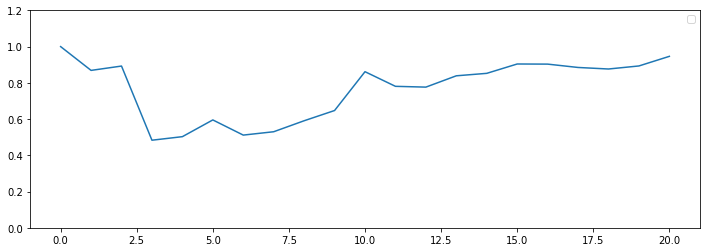

In [39]:
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt

clsCosine = []

for i, vec in enumerate(token_vecs_sum):
    pooler = 1 - cosine(token_vecs_sum[0].detach().cpu().numpy(), vec.detach().cpu().numpy())
    print('[CLS] vs ',tokenized_texts[i],' :  %f' % pooler)
    clsCosine.append(pooler)
    if tokenized_texts[i] == '[SEP]':
      break

plt.figure(figsize = (12,4)) 
plt.plot(clsCosine) 
plt.ylim(0,1.2)

plt.legend();

In [40]:
# weight = model.classifier.weight[0]

In [41]:
import tensorflow as tf
import numpy as np
from IPython.core.display import HTML, display

m = torch.nn.Linear(768, 2, bias=True).to(device)
# weight = torch.unsqueeze(weight, 0)
# weight = weight.to(device)
m.weight.data = model.classifier.weight.to(device)

n = torch.nn.ReLU()
d = torch.nn.Dropout(p=0.1, inplace=False)

In [45]:
result=[]

with torch.no_grad():
  def call_html(i, output, token_str, label):

    color = str(int(round(output*200)))

    pos = "<script type='text/javascript'> var span = document.createElement('span'); var newContent = document.createTextNode('"+token_str+" '); span.appendChild(newContent); span.style.color='rgb("+color+",0,0)'; document.body.appendChild(span); </script>"
    neg = "<script type='text/javascript'> var span = document.createElement('span'); var newContent = document.createTextNode('"+token_str+" '); span.appendChild(newContent); span.style.color='rgb(0,"+color+",0)'; document.body.appendChild(span); </script>"

    if label == 0:
      display(HTML(pos))
    else:
      display(HTML(neg))
    
  def vis(i, token_str, label):
    output = token_vecs_sum[i]
    output = output.to(device)
    output = m(output)
    result.append(output)
    result_output = torch.cat(result, dim=0)    
    output = n(output)
    output = output.detach().cpu().numpy()
    output= np.max(output[label])
    call_html(i, output, token_str, label)

    return result_output

In [46]:
for i, token_str in enumerate(tokenized_texts):
  if token_str == "[CLS]" or token_str == "[SEP]"  :
    continue 
    
  histogram = vis(i, token_str, label)

No handles with labels found to put in legend.


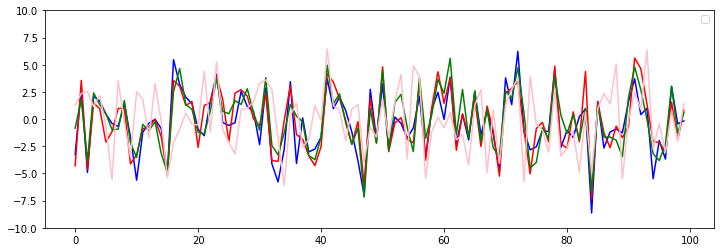

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize = (12,4)) 
plt.plot(token_vecs_sum[0][:100].detach().cpu().numpy(), color='blue')
plt.plot(token_vecs_sum[1][:100].detach().cpu().numpy(), color='red')
plt.plot(token_vecs_sum[2][:100].detach().cpu().numpy(), color='green')
plt.plot(token_vecs_sum[3][:100].detach().cpu().numpy(), color='pink')

plt.ylim(-10,10)

plt.legend();

챗봇 개발자 모임 https://www.facebook.com/groups/ChatbotDevKR/ 의 코드를 기반으로 작성하였음